In [14]:
import sys
sys.path.append("..")

import numpy as np
from gensim.models import Word2Vec, KeyedVectors

from src.seeds import Seeds
from src.gensim_word2vec_procrustes_align import smart_procrustes_align_gensim

### Find differences of meaning in time

The idea here is to consider the vectors coming from the different epochs and to find a difference in meaning in time. We can clearly see that some words change meaning by printing the top similar ones. For instance, the word drug is related to products in general, probably linked to the meaning of drugstore, while from 1920 on the word have a different context, related to narcotics.

To quantify this semantic shift we take the approach introduced here (https://gist.github.com/zhicongchen/9e23d5c3f1e5b1293b16133485cd17d8), that aligns the gensim models making them comparable.

We can see that the cosine similarity is increased when aligning two models, the idea now is to align models in a sequential fashion, so: 

align(2000, 1980), align(1980, 1960)... 

The models are aligned pairwise and the shift is detected comparing cosine similarities between adjacent years.

In [15]:
def print_similar(word, models, n=5):
    print(word)
    for y, m in models.items():
        try:
            print(f"\t{y}: {[e[0] for e in m.wv.most_similar(word, topn=n)]}")
        except:
            pass
        
def cos_sim(a, b):
    dot_product = np.dot(a, b) # x.y
    norm_a = np.linalg.norm(a) #|x|
    norm_b = np.linalg.norm(b) #|y|
    return dot_product / (norm_a * norm_b)

def get_similarity(m1, m2, word):
    try:
        return cos_sim(m1.wv[word], m2.wv[word])
    except:
        return -1
    
def get_similarity_sequence(models, couple_lists, word):
    return [get_similarity(models[s], models[e], word) for s, e in couple_lists]

def find_semantic_shift(models, couple_list, word, alpha=.9, threshold=.7):
    
    els = list(zip(couple_list, get_similarity_sequence(models, couple_list, word)))
    els = [e for e in els if e[1]>0]
    if not els:
        return []
    if len(els) == 1 and els[0][1] < threshold:
        return els
    
    # m = np.mean([e[1] for e in els if e[1]>0])
    # return [e for e in els if e[1] < alpha*m and e[1] != -1]
    return [e for e in els if e[1] < threshold and e[1] != -1]


def print_shift(semantic_shifts):
    if not semantic_shifts:
        print("No semantic shifts found.")
    else:
        s = "Semantic shifts found:\n\t"
        s += "\n\t".join([f"{e[0][0]} - {e[0][1]}: cos_sim {round(e[1], 2)}" 
                            for e in semantic_shifts])
        print(s)

### Aligning the models

### Detecting semantic shifts

In [17]:
directory = "../data/models/merged_time_vectors"

def get_name(s):
    s = s.split("/")[-1]
    l = s.split("_")
    return f"{l[0]}_{l[-2]}" if len(l)>2 else l[0]

models = { get_name(model_name) : Word2Vec.load(model_name) 
          for model_name in [f"{directory}/{el}" for el in sorted(os.listdir(directory)) if "npy" not in el]}

In [18]:
years = sorted(list(models.keys()), reverse=True)
couple_list = list(zip(years, years[1:]))
print(couple_list[:3], "...")

[('2010_2005', '2000'), ('2000', '1995'), ('1995', '1990')] ...


In [19]:
for base, other in couple_list:
    smart_procrustes_align_gensim(models[base], models[other])

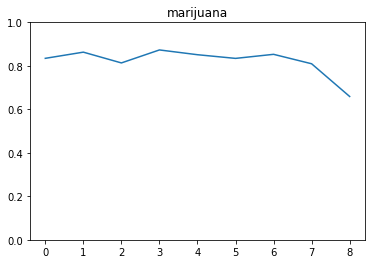

Semantic shifts found:
	1965_1960 - 1955_1945: cos_sim 0.6600000262260437
marijuana
	1955_1945: ['narcotic', 'dope', 'powder', 'capsule', 'beef', 'addict', 'drug', 'package', 'firearm', 'meat']
	1965_1960: ['heroin', 'packet', 'package', 'powder', 'capsule', 'cigarette', 'bag', 'vial', 'morphine', 'hypodermic']
	1970: ['heroin', 'narcotic', 'cocaine', 'capsule', 'amphetamine', 'morphine', 'cannabis', 'packet', 'tablet', 'hypodermic']
	1975: ['heroin', 'cocaine', 'lsd', 'narcotic', 'amphetamine', 'packet', 'cannabis', 'ounce', 'morphine', 'contraband']
	1980: ['heroin', 'cocaine', 'lsd', 'narcotic', 'cannabis', 'amphetamine', 'pcp', 'pill', 'ounce', 'cigarette']
	1985: ['heroin', 'cocaine', 'pcp', 'lsd', 'cigarette', 'cannabis', 'narcotic', 'smoke', 'ounce', 'amphetamine']
	1990: ['heroin', 'cocaine', 'pcp', 'cannabis', 'narcotic', 'cannabi', 'cigarette', 'lsd', 'snort', 'drug']
	1995: ['heroin', 'cocaine', 'pcp', 'narcotic', 'cigarette', 'smoke', 'lsd', 'bottle', 'ounce', 'kilogram']
	

In [23]:
import matplotlib.pyplot as plt
word = "marijuana"
x = get_similarity_sequence(models, couple_list, word)
plt.title(word)
plt.plot([e for e in x if e>0])
plt.ylim(0, 1)
plt.show()
print_shift(find_semantic_shift(models, couple_list, word))
print_similar(word, models, 10)

In [21]:
narcotics, _, _ = Seeds().get_starting_seeds()

In [22]:
for n in narcotics:
    print(n)
    print_shift(find_semantic_shift(models, couple_list, n))
    print_similar(n, models, 10)
    print()    

cannabis
Semantic shifts found:
	1970 - 1965_1960: cos_sim 0.44999998807907104
cannabis
	1955_1945: ['resin', 'poisonous', 'potato', 'mixture', 'metallic', 'membrane', 'noun', 'rag', 'perforate', 'marijuana']
	1965_1960: ['morphine', 'resin', 'dye', 'tablet', 'caustic', 'analyst', 'seed', 'vial', 'mixture', 'antique']
	1970: ['gram', 'marijuana', 'heroin', 'substance', 'amphetamine', 'cocaine', 'explosive', 'hypodermic', 'drug', 'narcotic']
	1975: ['substance', 'gram', 'marijuana', 'acid', 'heroin', 'lsd', 'amphetamine', 'cocaine', 'narcotic', 'hypodermic']
	1980: ['marijuana', 'heroin', 'cocaine', 'narcotic', 'gram', 'hypodermic', 'contraband', 'substance', 'amphetamine', 'packet']
	1985: ['gram', 'pcp', 'heroin', 'marijuana', 'cocaine', 'cannabi', 'lsd', 'substance', 'hypodermic', 'contraband']
	1990: ['lsd', 'heroin', 'marijuana', 'cocaine', 'narcotic', 'substance', 'gram', 'cannabi', 'contraband', 'pcp']
	1995: ['heroin', 'gram', 'cocaine', 'marijuana', 'narcotic', 'lsd', 'parapher